In [2]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator 

from statsmodels.tsa.stattools import adfuller, pacf, acf
from scipy.stats import shapiro, probplot # shapiro wilk test for normality sample size thousands or fewer
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
from statsmodels.tsa.arima_model import ARIMA

# Import Data

In [4]:


def importdata(key, path ,parseCol, From="2004-01-01", To="2019-09-01"):
    ''' 
    make sure the end date of the parse is shared between all datasets
    '''
    dataset = pd.read_csv("%s" %(path), index_col="%s" %(parseCol), parse_dates=["%s" %(parseCol)])
    if From==None and To==None:
        pass
    elif From and To:
        dataset = dataset.loc[From:To]
    return dataset


# import_PATH = r"\\ad.ucl.ac.uk\home0\zcecss0\DesktopSettings\Desktop\Research project\Data"    
import_PATH = r"C:\Users\sherv\OneDrive\Documents\GitHub\Python - Projects\Research Project\Data"
meta = {# dataset: [path, Date_col, Value_col]
        "Google":[f"{import_PATH}\multiTimeline.csv", "Month", "Top5"], 
#        "RDPI":  [f"{import_PATH}\RealDisposableIncome-2004-1_Present-Mon-US(Grab-30-11-18).csv", "DATE", "DSPIC96"], 
#        "CPI":   [f"{import_PATH}\CPI.csv", "DATE", "CPI"],
#        "GDP":   [f"{import_PATH}\GDP.csv", "DATE", "GDP"], 
#        "UE":    [f"{import_PATH}\Unemployment_2004_Present_US(Grab-5-12-18).csv", "DATE", "Value"], 
        "SP500": [f"{import_PATH}\S&P500.csv", "Date", "Close"], 
#        "IR":    [f"{import_PATH}\InterestRate_2004-1-1_Present_US(Grab-5-12-18).csv", "DATE", "FEDFUNDS"], 
#        "PPI":   [f"{import_PATH}\PPIACO.csv", "DATE", "PPI"],
#        "PMI":   [f"{import_PATH}\ISM-MAN_PMI.csv", "Date", "PMI"],
        "DJI":   [f"{import_PATH}\DJI.csv", "Date", "Close"]} 

data ={}
for key in meta.keys():
    data[key] = importdata(key, meta[key][0], meta[key][1])

# Visualise Data

In [ ]:

save_PATH = r"C:\Users\sherv\OneDrive\Documents\GitHub\Python - Projects\Research Project\Plots_Main"
minor_locator = AutoMinorLocator(12)
for key in data.keys():
    fig, ax1 = plt.subplots()
    data[key][meta[key][2]].plot(ax=ax1,color='k').xaxis.set_minor_locator(minor_locator)
    ax1.set_xlabel('Date')
    ax1.set_ylabel(key, color='k')
    plt.grid()
    Title = f"{key}"
#     ax2 = ax1.twinx()
#     data[key2][array2].plot(ax=ax2,color='r')
#     ax2.set_ylabel(array2, color='r')
#     ax2.tick_params('y', colors='r')
    plt.title(Title)
#    plt.savefig("%s\%s.png" %(save_PATH, Title))

1. Google data is limited to the dates ["2004-01-01":"2019-09-01"]
2. data undergoes structural break from 2008 to 2009 so model is best to be fit from 2009 onwards
3. train data is to be 95% of available data after parse

In [160]:
SP = data["SP500"]["Close"].loc["2009-01-01":"2018-12-01"]
DJI= data["DJI"]["Close"].loc["2009-01-01":"2018-12-01"]
GGL = data["Google"][meta["Google"][2]].loc["2009-01-01":"2018-12-01"]

# Data evaluation

1. Is variance constant over time? 
- Plot yearly variance (or growth rate), If growth present take logarithm
2. Is there seasonality?
- plot month's data over the years in box plot to compare seasonality
3. Is data stationary? 
- If ADF test, If no difference until stationary


#### Heteroskedacticity

__WHY DOES THE LOG ADF GIVE STATIONARITY?__

due to heteroskedasticity, test hypotheses are no longer valid which is why the t-stat results in type 1 errors. Also, the OLS estimators are no longer BLUE (best linear unbiased estimators) which allows us to perform tests such as: 
- Levene test: instead of Bartlett Test because its less sensitive to normality
- Breusch Pagan Test: assumes errors are normally distributed 
- Score Test: assumes error terms are iid (independent identically distributed)
- F Test: iid assumed for errors

log transformation of the data is unnecessary because there is no overal growth rate and the inflation appears to be linear. Therefore, log transforming the data meerly changes the scale of it and not yield any significance. 


# __In this section, to make the variance comparable and a relatable metric, the variances were normalised by variance.max(). Is this correct?__

In [ ]:
def var_growth_check(df):
    df_years = {}
    mm = [M for M in range(12)]
    for year in range(len(df)//12):
        val = []
        for M in mm:
            val.append(df.iloc[year*12+M])
        df_years[year] = val
    df_years = pd.DataFrame.from_dict(df_years)
    return df_years

DJI_year_var = var_growth_check(DJI)
SP_year_var = var_growth_check(SP)
GGL_year_var = var_growth_check(GGL)

fig, axes = plt.subplots(3,2,figsize=(15,12))
fig.suptitle("Yearly Variance Growth")
DJI.plot(ax=axes[0, 0], grid=True, color="k").xaxis.set_minor_locator(minor_locator)
axes[0,0].set(ylabel="DJI", xlim=["2009-01-01" , "2018-12-01"])
(DJI_year_var.var()/DJI_year_var.var().max()).plot(ax=axes[0, 1],grid=True, color="k", kind="bar") # is this normalisationcorrect
axes[0, 1].set(xlabel="Year index", ylabel="var(DJI)")
# axes[0, 1].tick_params(labelbottom=False)

SP.plot(ax=axes[1, 0], grid=True, color="k").xaxis.set_minor_locator(minor_locator)
axes[1,0].set(ylabel="SP500", xlim=["2009-01-01" , "2018-12-01"])
(SP_year_var.var()/SP_year_var.var().max()).plot(ax=axes[1, 1],grid=True, color="k", kind="bar")# is this normalisationcorrect
axes[1, 1].set(xlabel="Year index", ylabel="var(SP500)")
# axes[1, 1].tick_params(labelbottom=False)

GGL.plot(ax=axes[2,0], grid=True, color="k").xaxis.set_minor_locator(minor_locator)
axes[2,0].set(ylabel="Google", xlim=["2009-01-01" , "2018-12-01"])
(GGL_year_var.var()/GGL_year_var.var().max()).plot(ax=axes[2,1], grid=True, color="k", kind="bar")
axes[2, 1].set(xlabel="Year index", ylabel="var(GGL)")
# axes[2, 1].tick_params(labelbottom=False)

# plt.savefig()


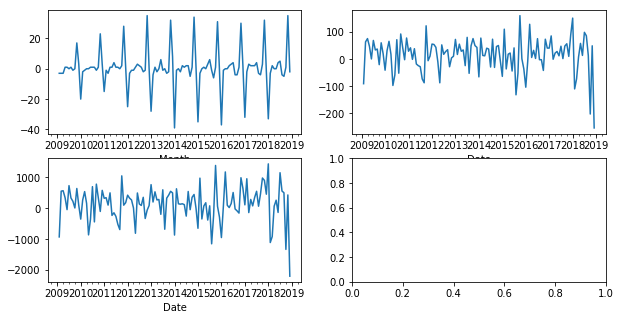

In [67]:
# test
fig, axes = plt.subplots(2,2, figsize=[10,5])
GGL.diff(1).dropna().plot(ax=axes[0,0])
SP.diff(1).dropna().plot(ax=axes[0,1])
DJI.diff(1).dropna().plot(ax=axes[1,0])

# Levene test (null says equal variance) cant use because data is not normal
# from scipy.stats import levene

# which function to use in the test
# ‘median’ : Recommended for skewed (non-normal) distributions>
# ‘mean’ : Recommended for symmetric, moderate-tailed distributions.
# ‘trimmed’ : Recommended for heavy-tailed distributions.
# def lev(data):
#     Levene = levene(data[len(data)//2:], data[:len(data//2)], center="trimmed")
#     print("Levene Test:")
#     print("\tstatistic=", Levene[0])
#     print("\tp-value=", Levene[1])
#     # with alpha = 0.05, if F>1.9855 regect null (sigma_1=sigma_2=...=sigma_p)
#     if Levene[1] <= 0.5:
#         rej = True
#     else:
#         rej = False
#     print("reject H_0:", rej)
    
# lev(GGL.diff(1).dropna())
# lev(SP.diff(1).dropna())
# lev(DJI.diff(1).dropna())




Berusch Pagan test:
$$\sigma_i = \sigma . f(\alpha_0 + \alpha z_i)$$
Homoscedasticity implies: $alpha=0$

In [ ]:
#Breusch Pagan Test
# from statsmodels.stats.diagnostic import het_breuschpagan
# from statsmodels.formula.api import ols



#Score Test

# F-test


$\rightarrow$ GARCH model to be applied

#### Seasonality

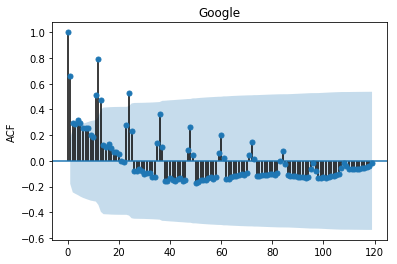

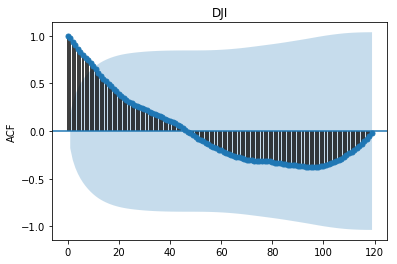

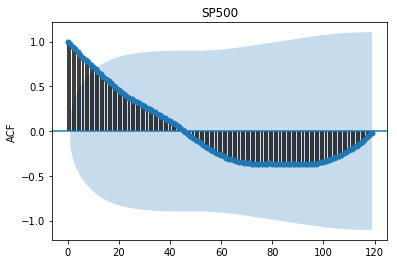

In [10]:
def acf_pacf(data, Title):
    fig, axes = plt.subplots(1,1)
    plot_acf(data, ax=axes, title=f"{Title}")
    axes.set(ylabel="ACF")
    
acf_pacf(GGL, "Google");
acf_pacf(DJI, "DJI");
acf_pacf(SP, "SP500");


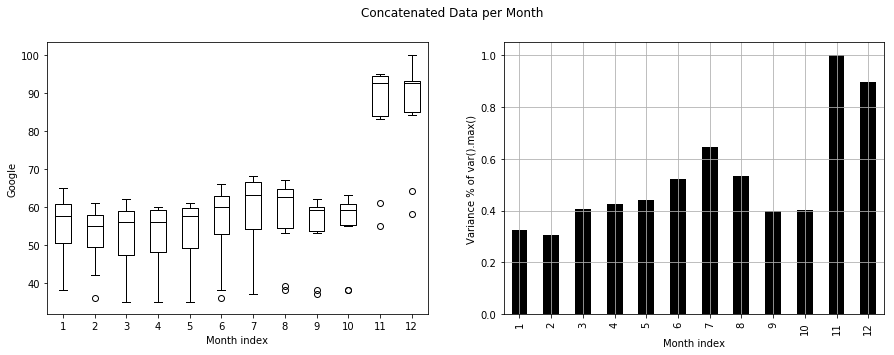

In [13]:
def seasonality_check(DF, Title, key=None, array=None, ):
    """
    data must not include incomplete years. 
    """
    if key and array: #check this line later
        df = data[key][array]
    else:
        df = DF
    mm = [M for M in range(1,13)]
    df_by_month = {}
    for M in mm:
        val = []
        for year in range(len(df)//12):
            val.append(df.iloc[year*12+M-1])
        df_by_month[M] = val
    df_by_month = pd.DataFrame.from_dict(df_by_month)    
    
    fig, axes = plt.subplots(1,2, figsize=(15,5))   
    fig.suptitle("Concatenated Data per Month")
    df_by_month.plot(ax=axes[0], kind="box" , color="k")
    (df_by_month.var()/df_by_month.var().max()).plot(ax=axes[1], kind="bar", grid=True, color="k") # is this normalisation correct?
    axes[0].set(ylabel=f"{Title}", xlabel="Month index")
    axes[1].set(xlabel="Month index", ylabel="Variance % of var().max()")
    return df_by_month


# DJI_by_month = seasonality_check(DJI, "DJI")
# SP_by_month = seasonality_check(SP, "SP500")
GGL_by_month = seasonality_check(GGL, "Google")

$\rightarrow$ seasonal trend seen

# Differencing




## Google

In [85]:
def ADF(array):
    ''' check for unit root errors in dataset'''
    result = adfuller(array)
    print('ADF t-Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if result[1] >= 0.05:
        rej = False
    else:
        rej = True
    print("reject H_0:", rej)
    

GGL_seasonal_diff = GGL.diff(12).dropna()
GGL_diff = GGL.diff(12).diff(1).dropna()


ADF(GGL_seasonal_diff)
ADF(GGL_diff)

ADF t-Statistic: -1.942644
p-value: 0.312274
Critical Values:
	1%: -3.494
	5%: -2.889
	10%: -2.582
reject H_0: False
ADF t-Statistic: -8.943531
p-value: 0.000000
Critical Values:
	1%: -3.494
	5%: -2.889
	10%: -2.582
reject H_0: True



$\rightarrow$ seasonal D=1 

$\rightarrow$ trend d=1

# ywunbiased why doesnt it work?
im not violating ant yw stationarity rules. I have tried everything:
- detrend (MA(12) and MA(4))
- take log
- difference a million times

__dont use mle because it assumes normality of data__

[Text(0,0.5,'PACF'), Text(0.5,0,'Lag')]

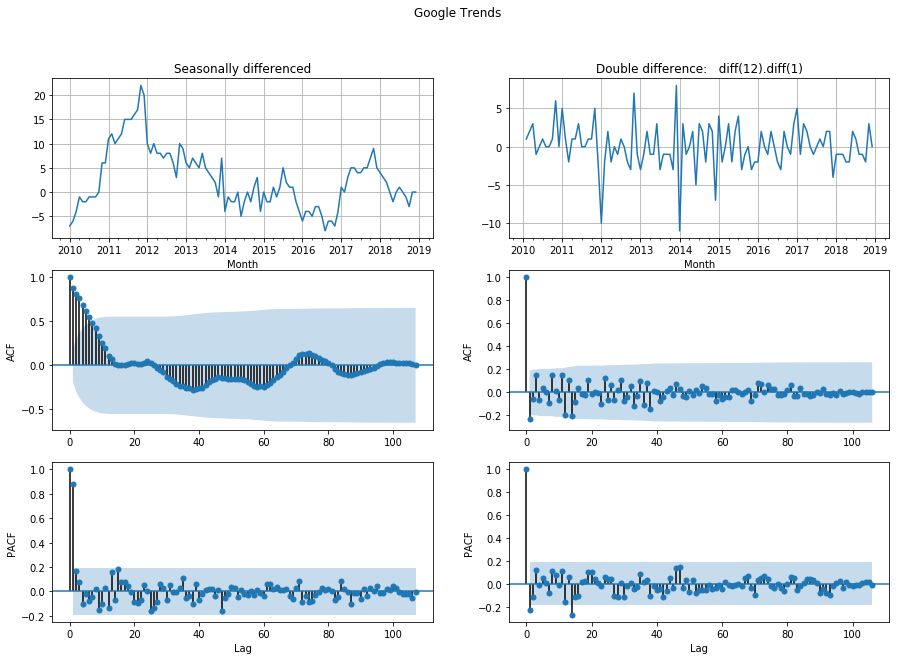

In [102]:
fig, axes = plt.subplots(3,2, figsize=[15,10])
fig.suptitle("Google Trends")
GGL_seasonal_diff.plot(ax=axes[0,0], grid=True, title="Seasonally differenced")
plot_acf(GGL_seasonal_diff, ax=axes[1,0], title="");
axes[1,0].set(ylabel="ACF")
plot_pacf(GGL_seasonal_diff, method="ywmle", ax=axes[2,0], title="");
axes[2,0].set(ylabel="PACF", xlabel="Lag")

GGL_double_diff.plot(ax=axes[0,1], grid=True, title="Double difference:   diff(12).diff(1)")
plot_acf(GGL_double_diff, ax=axes[1,1], title="");
axes[1,1].set(ylabel="ACF")
plot_pacf(GGL_double_diff, method="ywmle", ax=axes[2,1], title="");
axes[2,1].set(ylabel="PACF", xlabel="Lag")


$\rightarrow$ Start with  $GGL = ARIMA(1,1,1)(1,1,6)_{12}$


## SP500

ADF t-Statistic: -11.158240
p-value: 0.000000
Critical Values:
	1%: -3.487
	5%: -2.886
	10%: -2.580
reject H_0: True


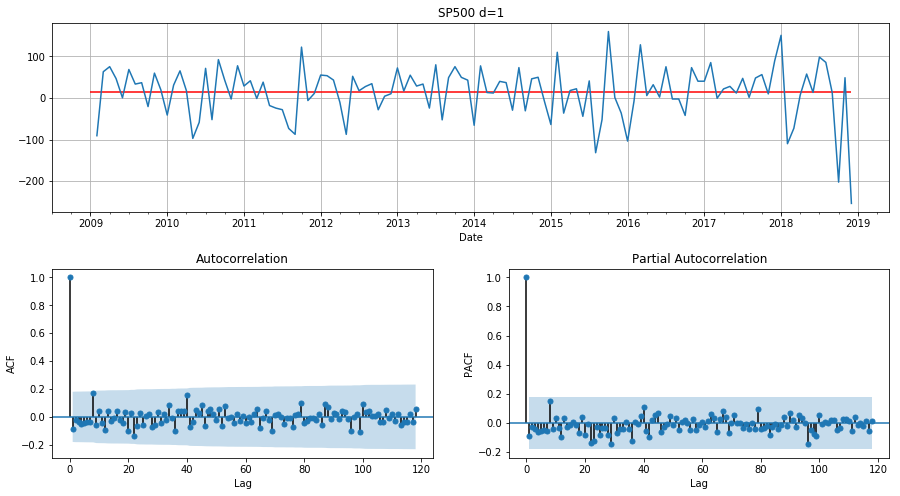

In [162]:
SP_diff = SP.diff(1).dropna()
ADF(SP_diff)

def coolplot(data, Title, pacfmethod="ywmle"):
    plt.figure(figsize=[15,8])
    grid = plt.GridSpec(2,2,wspace=0.2, hspace=0.3)
    ax1 = plt.subplot(grid[0,:])
    data.plot(ax=ax1, grid=True)
    plt.title(Title)
    plt.hlines(y=data.mean(), xmin="2009-01-01", xmax="2018-12-01", color="r")
    ax2 = plt.subplot(grid[1,0])
    plot_acf(data, ax=ax2)
    ax2.set(ylabel="ACF", xlabel="Lag")
    ax3 = plt.subplot(grid[1,1])
    plot_pacf(data, ax=ax3, method=pacfmethod)
    ax3.set(ylabel="PACF", xlabel="Lag")

coolplot(SP_diff, "SP500 d=1")

# DJI

ADF t-Statistic: -11.005346
p-value: 0.000000
Critical Values:
	1%: -3.487
	5%: -2.886
	10%: -2.580
reject H_0: True


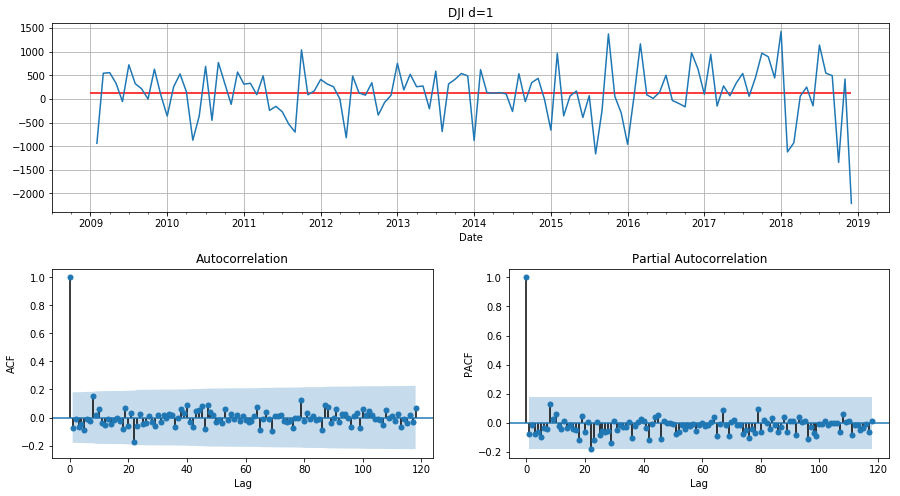

In [163]:
DJI_diff = DJI.diff(1).dropna()
ADF(DJI_diff)

coolplot(DJI_diff, "DJI d=1")

# SARIMA(p,d,q)(P,D,Q)$_m$

90% of the data is chosen as a training set and the remainder can be used as an in sample test of the fit.

In [167]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [101]:
def test_train(data):
    train, test = data.iloc[:round(len(data)*0.95)], data.iloc[round(len(data)*0.9):]
    return train, test

GGL_train, GGL_test = test_train(GGL_diff)[0], test_train(GGL_diff)[1]
SP_train, SP_test = test_train(SP_diff)[0], test_train(SP_diff)[1]
DJI_train, DJI_test = test_train(DJI_diff)[0], test_train(DJI_diff)[1]

## Google

In [227]:
GGL_model = SARIMAX(GGL, order=(2,1,0), seasonal_order=(1,1,0,12), simple_differencing=True)
GGL_fit = GGL_model.fit(disp=False)

C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


## SP500

# SP500 needs to be differenced twice or else SARIMAX gives non-stationarity error! but why does the ADF reject null?

In [226]:
SP_model = SARIMAX(SP_train, trend='c', order=(1,1,1))
SP_fit = SP_model.fit(disp=False)

C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


## DJI

In [224]:
DJI_model = SARIMAX(DJI_train, trend='c', order=(1,1,1))
DJI_fit = DJI_model.fit(disp=False)

C:\Users\sherv\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


# AIC, BIC, optimisation

Here we also check to see if there is overfitting etc (in sample forecast)

# GARCH(p,q)

# Residual analysis

# Break points

breaks_cusumolsresid
cusum test for parameter stability based on ols residuals
breaks_hansen
test for model stability, breaks in parameters for ols, Hansen 1992
recursive_olsresiduals
Calculate recursive ols with residuals and cusum test statistic. This is currently mainly helper function for recursive residual based tests. However, since it uses recursive updating and doesn’t estimate separate problems it should be also quite efficient as expanding OLS function.


https://en.wikipedia.org/wiki/Structural_break


# VAR and ARDL

# Forecast horizon 

# Forecasting (KMC)

# Test reference
http://www.statsmodels.org/stable/diagnostic.html?highlight=heteroscedasticity
